In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [18]:
data = {
    "state": np.random.randint(0, 10, 1000),
    "action": np.random.randint(0, 4, 1000),
    "reward": np.random.choice([0, 1], 1000),
    "next_state": np.random.randint(0, 10, 1000)
}
dataset = pd.DataFrame(data)

In [19]:
scaler = MinMaxScaler()
dataset[["state", "next_state"]] = scaler.fit_transform(dataset[["state", "next_state"]])


In [27]:
def build_dqn(n_states, n_actions):
    model = Sequential([
        Dense(24, input_dim=n_states, activation='relu'),
        Dense(24, activation='relu'),
        Dense(n_actions, activation='linear')
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
    return model

In [28]:
n_states = 1  # Since we normalize states, it's a single continuous feature
n_actions = 4  # Number of actions
model = build_dqn(n_states, n_actions)



In [29]:
discount_factor = 0.9
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
epochs = 200  # Reduced epochs for faster training
batch_size = 32  # Mini-batch training
reward_tracking = []


In [30]:
states = dataset["state"].values.reshape(-1, 1)
actions = dataset["action"].values
rewards = dataset["reward"].values
next_states = dataset["next_state"].values.reshape(-1, 1)


In [31]:
def train_batch():
    indices = np.random.choice(len(states), batch_size)
    batch_states = states[indices].reshape(batch_size, -1)
    batch_actions = actions[indices]
    batch_rewards = rewards[indices]
    batch_next_states = next_states[indices].reshape(batch_size, -1)
    
    q_values = model.predict(batch_states, verbose=0)
    next_q_values = model.predict(batch_next_states, verbose=0)
    
    for i in range(batch_size):
        action = int(batch_actions[i])
        q_values[i, action] = batch_rewards[i] + discount_factor * np.max(next_q_values[i])
    
    model.fit(batch_states, q_values, verbose=0, epochs=1, batch_size=batch_size)

In [32]:
for epoch in range(epochs):
    total_epoch_reward = 0
    for _ in range(len(states) // batch_size):
        train_batch()
    
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    total_epoch_reward = np.sum(rewards)
    reward_tracking.append(total_epoch_reward)

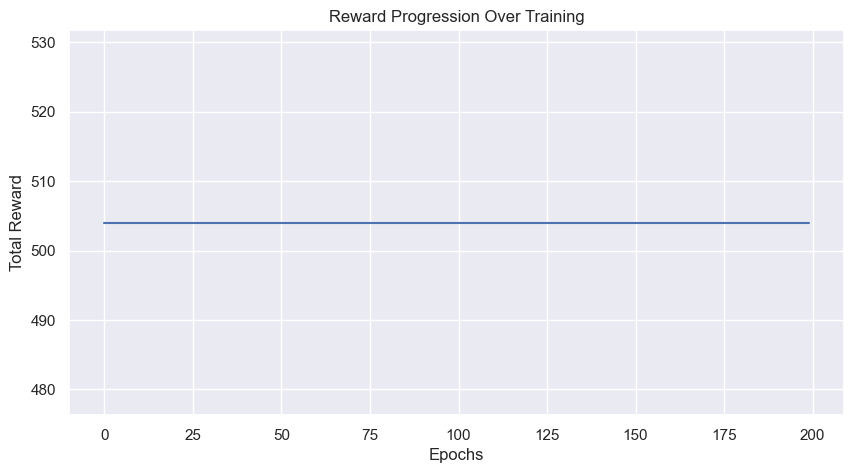

In [33]:
sns.set(style="darkgrid")
def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(len(rewards)), y=rewards)
    plt.xlabel("Epochs")
    plt.ylabel("Total Reward")
    plt.title("Reward Progression Over Training")
    plt.show()

plot_rewards(reward_tracking)


In [34]:
total_rewards = 0
test_episodes = 10
for _ in range(test_episodes):
    state = np.array([[random.random()]])  # Random normalized state
    done = False
    while not done:
        q_values = model.predict(state.reshape(1, -1), verbose=0)
        action = np.argmax(q_values)
        next_state = np.array([[random.random()]])
        reward = 1 if random.random() > 0.5 else 0
        total_rewards += reward
        state = next_state
        done = random.random() > 0.8

print(f"Average reward over {test_episodes} test episodes: {total_rewards / test_episodes}")

Average reward over 10 test episodes: 4.1
